# Experiment: Varying N in top-N DDA fragmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import sys
from collections import defaultdict
import seaborn as sns

In [3]:
sys.path.append('../codes')

In [4]:
from VMSfunctions.Chemicals import *
from VMSfunctions.Chromatograms import *
from VMSfunctions.MassSpec import *
from VMSfunctions.Controller import *
from VMSfunctions.Common import *
from VMSfunctions.DataGenerator import *
from VMSfunctions.Noise import *

### Useful functions

Performance is calculated by precision, recall and the mean square error of intensity when the fragmentation event occur to the maximum intensity of the chromatographic peak.

In [5]:
def find_chem(to_find, chem_list):
    for chem in chem_list:
        assert chem is not None
        assert to_find is not None
        if chem.max_intensity == to_find.max_intensity and \
            chem.rt == to_find.rt and \
            chem.chromatogram == to_find.chromatogram:
            return chem
    return None

In [6]:
def count_fragmented(chem, fragmented_chems):
    peaks = fragmented_chems[chem]
    ms_counts = defaultdict(int)
    for p in peaks:
        ms_counts[p.ms_level] += 1
    return ms_counts

In [7]:
def get_frag_events(controller, ms_level):
    filtered_frag_events = list(filter(lambda x: x.ms_level == ms_level, controller.mass_spec.fragmentation_events))
    chem_to_frag_events = defaultdict(list)
    for frag_event in filtered_frag_events:
        chem_to_frag_events[frag_event.chem].append(frag_event)
    return dict(chem_to_frag_events)

def count_frag_events(chem, chem_to_frag_events):
    return len(chem_to_frag_events[chem])

def get_chem_frag_counts(chem_list, chem_to_frag_events):
    results = {}
    for i in range(len(chem_list)):
        chem = chem_list[i]
        found = find_chem(chem, chem_to_frag_events)
        try:
            count = count_frag_events(found, chem_to_frag_events)
        except KeyError:
            count = 0
        results[chem] = count
    return results

In [8]:
def compute_performance(controller, dataset):
    ms_level = 2
    chem_to_frag_events = get_frag_events(controller, ms_level)
    positives = list(filter(lambda x: x.type == 'data', dataset))
    negatives = list(filter(lambda x: x.type == 'noise', dataset))
    positives_count = get_chem_frag_counts(positives, chem_to_frag_events)
    negatives_count = get_chem_frag_counts(negatives, chem_to_frag_events)    

    # count the following:
    # true positive = is a real data and is fragmented
    # false positive = is not a real data but is fragmented
    # false negative = is a real data but is not fragmented

    tp = len([chem for chem in positives if positives_count[chem] > 0])
    fp = len([chem for chem in negatives if negatives_count[chem] > 0])
    fn = len([chem for chem in positives if positives_count[chem] == 0])

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = ( 2 * prec * rec) / (prec + rec)
    prec, rec, f1
    
    print('tp=%d fp=%d fn=%d prec=%.3f rec=%.3f f1=%.3f' % (tp, fp, fn, prec, rec, f1))
    return tp, fp, fn, prec, rec, f1

In [17]:
def load_controller(results_dir, N, rt_tol):
    analysis_name = 'experiment_N_%d_rttol_%d' % (N, rt_tol)    
    pickle_in = '%s/%s.p' % (results_dir, analysis_name) 
    print('Loading %s' % analysis_name)                    
    try:
        controller = load_obj(pickle_in)
    except FileNotFoundError:
        controller = None
    return controller

### Load experiment results

In [10]:
results_dir = '../models/dda_results'

In [11]:
dataset = load_obj('%s/noisy_dataset.p' % results_dir)

### Compute performance

In [12]:
%matplotlib inline

#### Fixed N = 10 and varying rt_tols

In [18]:
Ns = [10]
rt_tols = list(range(5, 31, 5))
results = []
for N in Ns:
    for rt_tol in rt_tols:
        controller = load_controller(results_dir, N, rt_tol)
        if controller is not None:
             res = (N, rt_tol) + compute_performance(controller, dataset)            
        results.append(res)

Loading experiment_N_10_rttol_5
tp=1226 fp=756 fn=8598 prec=0.619 rec=0.125 f1=0.208
Loading experiment_N_10_rttol_10
tp=1151 fp=623 fn=8673 prec=0.649 rec=0.117 f1=0.198
Loading experiment_N_10_rttol_15
tp=1062 fp=525 fn=8762 prec=0.669 rec=0.108 f1=0.186
Loading experiment_N_10_rttol_20
tp=983 fp=475 fn=8841 prec=0.674 rec=0.100 f1=0.174
Loading experiment_N_10_rttol_25
tp=928 fp=445 fn=8896 prec=0.676 rec=0.094 f1=0.166
Loading experiment_N_10_rttol_30
tp=872 fp=422 fn=8952 prec=0.674 rec=0.089 f1=0.157


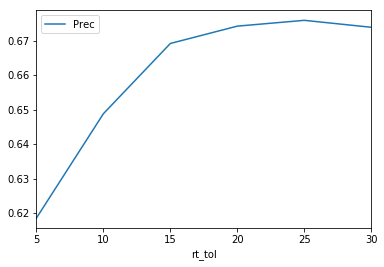

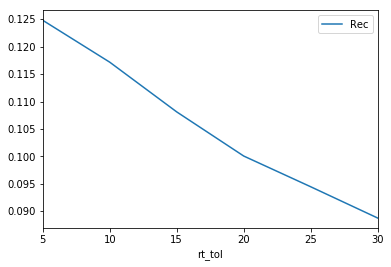

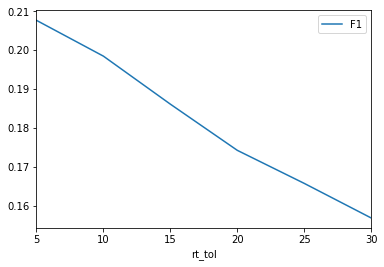

In [19]:
df = pd.DataFrame(results, columns=['N', 'rt_tol', 'TP', 'FP', 'FN', 'Prec', 'Rec', 'F1'])
df.plot.line(x='rt_tol', y=['Prec'])
df.plot.line(x='rt_tol', y=['Rec'])
df.plot.line(x='rt_tol', y=['F1'])

In [20]:
df

,N,rt_tol,TP,FP,FN,Prec,Rec,F1
0,10,5,1226,756,8598,0.618567,0.124796,0.207691
1,10,10,1151,623,8673,0.648816,0.117162,0.198482
2,10,15,1062,525,8762,0.669187,0.108103,0.186136
3,10,20,983,475,8841,0.674211,0.100061,0.174260
4,10,25,928,445,8896,0.675892,0.094463,0.165759
5,10,30,872,422,8952,0.673879,0.088762,0.156863


#### Fixed rt_tol = 15 and varying Ns

In [23]:
Ns = list(range(10, 101, 10)) # top-N DDA fragmentation
Ns

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [24]:
rt_tol = 15
Ns = list(range(2, 101, 2)) # top-N DDA fragmentation
Ns = list(range(10, 101, 10)) # top-N DDA fragmentation
results = []
for N in Ns:
    controller = load_controller(results_dir, N, rt_tol)
    if controller is not None:
         res = (N, rt_tol) + compute_performance(controller, dataset)            
    results.append(res)

Loading experiment_N_10_rttol_15
tp=1062 fp=525 fn=8762 prec=0.669 rec=0.108 f1=0.186
Loading experiment_N_20_rttol_15
tp=1854 fp=1003 fn=7970 prec=0.649 rec=0.189 f1=0.292
Loading experiment_N_30_rttol_15
tp=2567 fp=1336 fn=7257 prec=0.658 rec=0.261 f1=0.374
Loading experiment_N_40_rttol_15
tp=3109 fp=1622 fn=6715 prec=0.657 rec=0.316 f1=0.427
Loading experiment_N_50_rttol_15
tp=3583 fp=1873 fn=6241 prec=0.657 rec=0.365 f1=0.469
Loading experiment_N_60_rttol_15
tp=3983 fp=2046 fn=5841 prec=0.661 rec=0.405 f1=0.502
Loading experiment_N_70_rttol_15
tp=4274 fp=2203 fn=5550 prec=0.660 rec=0.435 f1=0.524
Loading experiment_N_80_rttol_15
tp=4494 fp=2323 fn=5330 prec=0.659 rec=0.457 f1=0.540
Loading experiment_N_90_rttol_15
tp=4555 fp=2447 fn=5269 prec=0.651 rec=0.464 f1=0.541
Loading experiment_N_100_rttol_15
tp=4708 fp=2522 fn=5116 prec=0.651 rec=0.479 f1=0.552


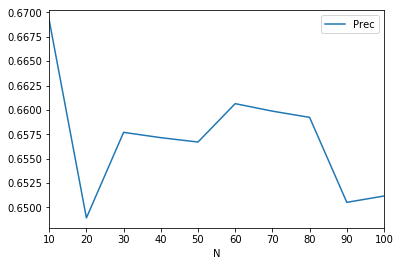

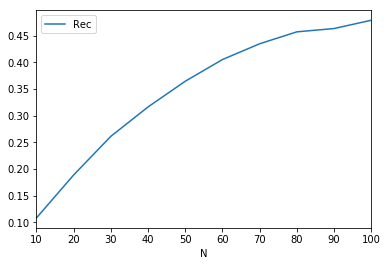

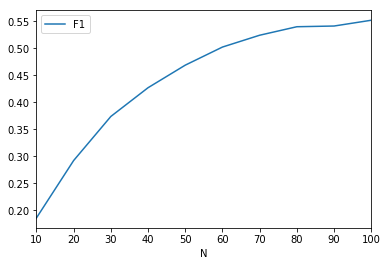

In [25]:
df = pd.DataFrame(results, columns=['N', 'rt_tol', 'TP', 'FP', 'FN', 'Prec', 'Rec', 'F1'])
df.plot.line(x='N', y=['Prec'])
df.plot.line(x='N', y=['Rec'])
df.plot.line(x='N', y=['F1'])

In [26]:
df

,N,rt_tol,TP,FP,FN,Prec,Rec,F1
0,10,15,1062,525,8762,0.669187,0.108103,0.186136
1,20,15,1854,1003,7970,0.648932,0.188721,0.292406
2,30,15,2567,1336,7257,0.657699,0.261299,0.374007
3,40,15,3109,1622,6715,0.657155,0.316470,0.427207
4,50,15,3583,1873,6241,0.656708,0.364719,0.468979
5,60,15,3983,2046,5841,0.660640,0.405436,0.502492
6,70,15,4274,2203,5550,0.659873,0.435057,0.524385
7,80,15,4494,2323,5330,0.659234,0.457451,0.540112
8,90,15,4555,2447,5269,0.650528,0.463660,0.541424
9,100,15,4708,2522,5116,0.651176,0.479235,0.552129


### Compute performance for varying Ns and rt_tols

In [ ]:
Ns = list(range(2, 51, 2)) # top-N DDA fragmentation
rt_tols = list(range(5, 31, 5)) # the rt window around a selected precursor ion to prevent it from fragmented multiple times

In [ ]:
X, Y = np.meshgrid(Ns, rt_tols)
Z_precision = np.zeros_like(X).astype(float)
Z_recall = np.zeros_like(X).astype(float)
Z_f1 = np.zeros_like(X).astype(float)

In [ ]:
for j in range(X.shape[1]):
    for i in range(X.shape[0]):    
        N = X[i, j]
        rt_tol = Y[i, j]            
        analysis_name = 'experiment_N_%d_rttol_%d' % (N, rt_tol)    
        pickle_in = '%s/%s.p' % (results_dir, analysis_name) 

        print('Loading %s' % analysis_name)                    
        try:
            controller = load_obj(pickle_in)
        except FileNotFoundError:
            controller = None

        # compute performance
        if controller is not None:
            tp, fp, fn, prec, rec, f1 = compute_performance(controller, dataset)
            Z_precision[i, j] = prec
            Z_recall[i, j] = rec
            Z_f1[i, j] = f1

### Make plot

In [ ]:
plot_data = {
    'X': X,
    'Y': Y,
    'Z_precision': Z_precision,
    'Z_recall': Z_recall,
    'Z_f1': Z_f1
}

In [ ]:
save_obj(plot_data, results_dir + '/plot_data.p')

In [ ]:
def make_plot(X, Y, Z, xlabel, ylabel, zlabel, title):
    # Plot the surface.
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    # ax.set_zlim(-1.01, 1.01)
    # ax.zaxis.set_major_locator(LinearLocator(10))
    # ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)    
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
%matplotlib notebook

In [ ]:
make_plot(X, Y, Z_precision, 'N', 'Dynamic exclusion window (s)', 'Precision', 'Precision with varying Ns and dynamic exclusion windows')

In [ ]:
make_plot(X, Y, Z_recall, 'N', 'Dynamic exclusion window (s)', 'Recall', 'Recall with varying Ns and dynamic exclusion windows')

In [ ]:
make_plot(X, Y, Z_f1, 'N', 'Dynamic exclusion window (s)', 'F_1', 'F_1 score with varying Ns and dynamic exclusion windows')

In [ ]:
%matplotlib inline

In [ ]:
make_plot(X, Y, Z_precision, 'N', 'Dynamic exclusion window (s)', 'Precision', 'Precision with varying Ns and dynamic exclusion windows')

In [ ]:
make_plot(X, Y, Z_recall, 'N', 'Dynamic exclusion window (s)', 'Recall', 'Recall with varying Ns and dynamic exclusion windows')

In [ ]:
make_plot(X, Y, Z_f1, 'N', 'Dynamic exclusion window (s)', 'F_1', 'F_1 score with varying Ns and dynamic exclusion windows')